In [18]:
import os
import sys

import math
from copy import deepcopy

import matplotlib.pyplot as plt
import sympy as sm
import networkx as nx

import numpy
from numpy import dot

import pprint
from pprint import pprint

import json

sys.path.append(os.path.abspath('../'))

from gpa.utils import disp_error_plot, disp_graph_with_custom_labels
from gpa.GPA import GPA


## Чтение файла с описанием структуры трубопровода

In [19]:
path = 'models/gpa-1.json'

with open(path, 'r') as fp:
    gpa1 = json.load(fp)

## Создание экземляра "объекта-трубопровода" для дальнеших вычислений

In [20]:
GPA_1 = GPA(gpa1)

## Граф с указаниями имен неизвестных

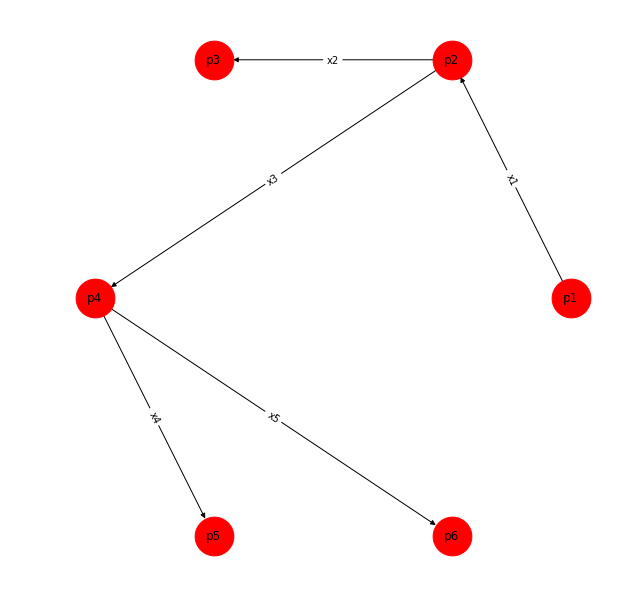

In [21]:
disp_graph_with_custom_labels(gr=GPA_1.gpa, 
                              edge_label='var', 
                              node_label='var')

## Граф с указанием известных и неизвестных значений

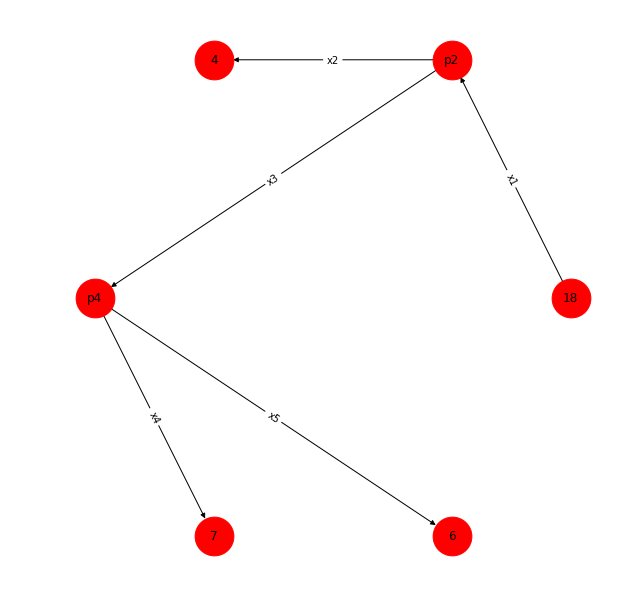

In [22]:
disp_graph_with_custom_labels(gr=GPA_1.gpa, 
                              edge_label='x', 
                              node_label='P')

## Переменные, которые будут найдены из уравнений

In [23]:
GPA_1.variables

[p2, p4, x1, x2, x3, x4, x5]

## Построенная система уравнений

In [24]:
pprint(GPA_1.equations)

Matrix([
[    -p2**2 - x1**2 + 324],
[   p2**2 - p4**2 - x3**2],
[      p2**2 - x2**2 - 16],
[      p4**2 - x4**2 - 49],
[      p4**2 - x5**2 - 36],
[1.0*x1 - 1.0*x2 - 1.0*x3],
[1.0*x3 - 1.0*x4 - 1.0*x5]])


In [25]:
appoximation = GPA_1.solve_equations(start_approximation=gpa1['approximation'])
GPA_1.construct_sense_matrix()

## График критерия остановки поиска решения
### $ | P_{i + 1} - P_{i} | < \epsilon $ , где  $ P_{i} $ - вектор значений переменных на шаге $ i $ 

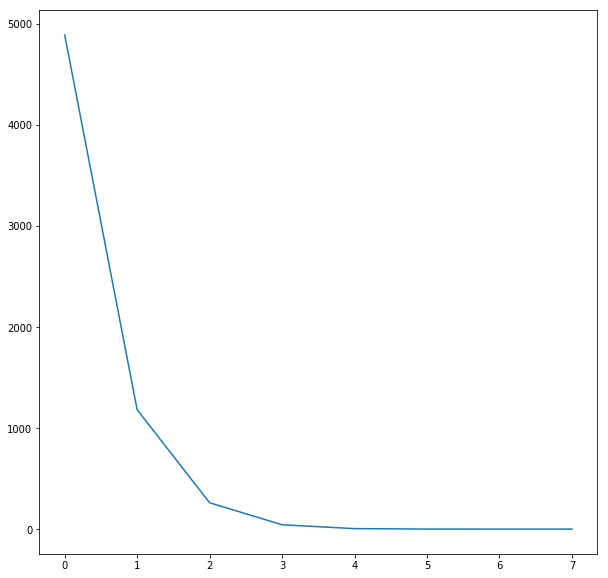

In [26]:
disp_error_plot(errors=GPA_1.solving_errors)

## Итоговые значения всех искомых переменных после решения системы

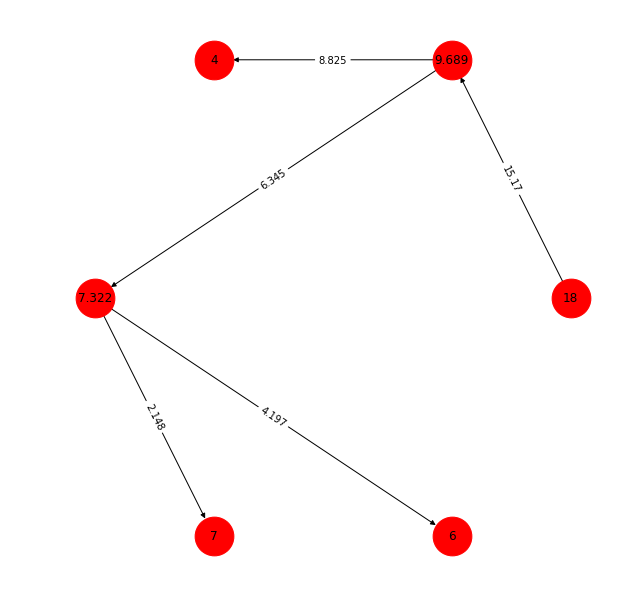

In [27]:
disp_graph_with_custom_labels(gr=GPA_1.gpa, 
                              edge_label='x', 
                              node_label='P')

## Полученные соотношения для 
### $ dp_{2}, dp_{4}, dq_{1}, dq_{3}, dq_{5}, dq_{6} $ ### 
## соответственно 

In [28]:
pprint(GPA_1.dp_var)
pprint(GPA_1.dq_var)

Matrix([
[ 0.653251212606509*p1 - 1.12294031214548*p3 + 1.68373964655373*p5 + 0.861597175409854*p6],
[0.23835509075696*p1 - 0.409732940177964*p3 - 0.463793620254566*p5 - 0.237330797550768*p6]])
Matrix([
[   -1.41382885723871*p1 + 1.33244380210664*p3 - 1.99786972837884*p5 - 1.02234268720305*p6],
[0.296098622690364*p1 + 0.588936999423087*p3 + 0.763187240517267*p5 + 0.390535420416338*p6],
[  0.776949338813993*p1 - 1.33557767090522*p3 + 1.89777722120371*p5 - 0.773610522232499*p6],
[ 0.340780895734351*p1 - 0.585803130624508*p3 - 0.663094733342142*p5 + 1.40541778901921*p6]])
